## Modern convnet architecture patterns

In [1]:
import os
import sys
import shutil
import pathlib
import matplotlib.pyplot as plt

import numpy as np
import tensorflow as tf

from IPython.core.magic import register_cell_magic

os.environ["KERAS_BACKEND"] = "jax"

import keras

@register_cell_magic
def backend(line, cell):
    current, required = os.environ.get("KERAS_BACKEND", ""), line.split()[-1]
    if current == required:
        get_ipython().run_cell(cell)
    else:
        print(
            f"This cell requires the {required} backend. To run it, change KERAS_BACKEND to "
            f"\"{required}\" at the top of the notebook, restart the runtime, and rerun the notebook."
        )

---

## Residual connections

<!-- ![Chollet residual](images/chollet/figure9.3.png) -->
<img src="https://raw.githubusercontent.com/jchwenger/AI/main/lectures/07/images/chollet/figure9.3.png">

[DLWP](https://deeplearningwithpython.io/chapters/chapter09_convnet-architecture-patterns/#residual-connections), Figure 9.3

Residual connections address two problems:
1. Information bottlenecks;
2. Vanishing gradients.

### 1. Information bottlenecks

The representational power of a layer is limited by its size: information can get lost in the processing pipeline.

*For example, high frequency information can never be recovered by later layers if there is a low pass filter early on.*

Residual connections re-inject the information content of earlier layer outputs.

### 2. Vanishing gradients

During backpropagation, we apply the **chain rule**, as we have seen, which means that we multiply the gradients of each node in our network.

As we saw in the case of RNNs, multiplying either small numbers will make them smaller!

Suppose layer 1 is the top layer, layer 2 is the first hidden layer from the top etc, the gradient of the loss with respect to a weight in layer 8 is:

$$
\frac{d  \mathcal{L} }{d X_1} = \frac{d \mathcal{L} }{d  X_L} \frac{d  X_L}{d X_{L-1}} \frac{ d X_{L-1}}{ d X_{L-2} } \ldots \frac{d X_2}{d  X_1}$$

A product of layer gradients $\frac{dL_{i+1}}{dL_i}$, with $X_1$ being the 'shallowest' (or first) layer, and $X_L$ the 'deepest' (or last, before the loss).

The combined product can get **very small** if the layer gradients have an absolute value less than 1.

#### Residual connections: the maths

A consequence of all this is that it incentivises the network to learn the **difference** between the previous step and the new one.

Indeed, the transformed representation will be re-added to its input: what is encoded by the layer is **how the input should change**.

Instead of $X_{l+1} = \mathcal{H}(X_l)$, where $\mathcal{H}$ is the layer transformation, $X_{l+1}$ the layer output and $X_l$ its input, we learn: 

$$X_{l+1} = X_l + \mathcal{F}(X_l, W_l)$$

With $\mathcal{F}$ being the $l$-th residual unit with any number of layers containing the weights $W_l$.

Here is an example of what this could look like (**BN** stands for batch normalization, **weight** for your standard affine transform $\sigma(wx + b)$):

<!-- ![He residual unit](images/he.residual-unit.png) -->
<img style="height:400px" src="https://raw.githubusercontent.com/jchwenger/AI/main/lectures/07/images/he.residual-unit.png">

Stacking such blocks would allow us to reuse the definition above:

$$
\begin{aligned}
X_{l+2} &= {\color{blue} X_{l+1} } + \mathcal{F}(X_{l+1}, W_{l+1}) \\
\\
& =  { \color{blue}X_l + \mathcal{F}(X_l, W_l) } + \mathcal{F}(X_{l+1}, W_{l+1})
\end{aligned}
$$

Therefore, if we have more, the initial input remains, and is only modified by **a sum** of the results of the residual units (as opposed to a **product**, without the skip-connections):

$$ X_{L} = X_{l} + \sum_{i=l}^{L-1} \mathcal{F}(X_i, W_i) $$

Backpropagation will then be written like so:

$$
\begin{aligned}
\frac{d \mathcal{L}}{d X_l} &= \frac{d \mathcal{L}}{d X_L} \frac{d { \color{orange} X_L } }{d X_l} \\
\\
& = \frac{d \mathcal{L}}{d X_L} \frac{ d ({\color{orange} X_{l} + \sum_{i=l}^{L-1} \mathcal{F}(X_i, W_i) }) }{d X_l} \\
\\
& = \frac{d \mathcal{L}}{d X_L} (\frac{ d { \color{orange} X_{l} } }{ d X_l }  + \frac{ { \color{orange} \sum_{i=l}^{L-1} \mathcal{F}(X_i, W_i) } }{d X_l}) \\
\\
& =  \frac{d \mathcal{L}}{d X_L} ( 1 + \frac{ d }{d X_l} {\color{orange}\sum_{i=l}^{L-1} \mathcal{F}(X_i, W_i) }  ) \\
\\
& =  \underbrace{\frac{d \mathcal{L}}{d X_L}}_{\substack{ \text{backpropagates signal back to } X_l\\ \text{no matter what intermediate} \\ \text{transformations do} } } +  \underbrace{ \frac{d \mathcal{L}}{d X_L} \frac{ d }{d X_l} \sum_{i=l}^{L-1} \mathcal{F}(X_i, W_i) )}_{ \substack{ \text{can become very small without} \\ \text{affecting overall training} } } \\
\end{aligned}
$$

With $\mathcal{L}$ as our loss.

Reference: [He et al, "Identity Mappings in Deep Residual Networks", 2016](http://arxiv.org/abs/1603.05027)

#### Note: LSTM carry

The LSTM **carry** (memory) propagates information forward in time and helps avoid vanishing gradients in recurrent networks. The residual connection has a similar effect!

### Residual block where the number of filters changes

In [2]:
inputs = keras.Input(shape=(32, 32, 3))
x = keras.layers.Conv2D(32, 3, activation="relu")(inputs)

residual = x                                                            # 1. save the current state of x (residual)

                                                   # ↓ keep dimensions the same!
x = keras.layers.Conv2D(64, 3, activation="relu", padding="same")(x) # 2.a the first branch


residual = keras.layers.Conv2D(64, 1)(residual)                      # 2.b the second branch
                                                                        # (transform residual with Conv2D and
                                                                        # just 1 filter so that the shapes work)

x = keras.layers.add([x, residual])                                  #  reinject past x

### Residual block where the target block includes a max pooling layer

In [3]:
inputs = keras.Input(shape=(32, 32, 3))
x = keras.layers.Conv2D(32, 3, activation="relu")(inputs)

residual = x                                                            # 1. save the current state of x (residual)

                                                 # ↓ keep dimensions the same!
x = keras.layers.Conv2D(64, 3,activation="relu", padding="same")(x) # 2.a the first branch
                                  # ↓ also with MaxPooling (rare)
x = keras.layers.MaxPooling2D(2, padding="same")(x)

residual = keras.layers.Conv2D(64, 1, strides=2)(residual)           # 2.b the second branch
                                                                        # (transform residual with Conv2D and
                                                                        # just 1 filter so that the shapes work)

x = keras.layers.add([x, residual]) # merging current and residual

In [4]:
inputs = keras.Input(shape=(32, 32, 3))
x = keras.layers.Rescaling(1./255)(inputs)

def residual_block(x, filters, pooling=False):
    residual = x                                                                 # ← SAVE
    x = keras.layers.Conv2D(filters, 3, activation="relu", padding="same")(x) #   branch 1
    x = keras.layers.Conv2D(filters, 3, activation="relu", padding="same")(x)
    if pooling:
        x = keras.layers.MaxPooling2D(2, padding="same")(x)
        residual = keras.layers.Conv2D(filters, 1, strides=2)(residual)       #   branch 2
    elif filters != residual.shape[-1]:
        residual = keras.layers.Conv2D(filters, 1)(residual)                  #   branch 2
    x = keras.layers.add([x, residual])                                       # ← REINJECT
    return x

x = residual_block(x, filters=32, pooling=True)
x = residual_block(x, filters=64, pooling=True)
x = residual_block(x, filters=128, pooling=False)

x = keras.layers.GlobalAveragePooling2D()(x)
outputs = keras.layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 32, 32, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 32, 32, 3)      │              0 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 32, 32, 32)     │            896 │ rescaling[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 32, 32, 32)     │          9,248 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 16, 16, 32)     │              0 │ conv2d_7[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 16, 16, 32)     │            128 │ rescaling[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_2 (Add)               │ (None, 16, 16, 32)     │              0 │ max_pooling2d_1[0][0], │
│                           │                        │                │ conv2d_8[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 16, 16, 64)     │         18,496 │ add_2[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_10 (Conv2D)        │ (None, 16, 16, 64)     │         36,928 │ conv2d_9[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 8, 8, 64)       │              0 │ conv2d_10[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_11 (Conv2D)        │ (None, 8, 8, 64)       │          2,112 │ add_2[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_3 (Add)               │ (None, 8, 8, 64)       │              0 │ max_pooling2d_2[0][0], │
│                           │                        │                │ conv2d_11[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_12 (Conv2D)        │ (None, 8, 8, 128)      │         73,856 │ add_3[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_13 (Conv2D)        │ (None, 8, 8, 128)      │        147,584 │ conv2d_12[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_14 (Conv2D)        │ (None, 8, 8, 128)      │          8,320 │ add_3[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_4 (Add)               │ (None, 8, 8, 128)      │              0 │ conv2d_13[0][0],       │
│                           │                        │                │ conv2d_14[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_poolin

 Total params: 297,697 (1.14 MB)

 Trainable params: 297,697 (1.14 MB)

 Non-trainable params: 0 (0.00 B)

---

## Batch normalization

The output from a layer might have some large values – and these will dominate training.

Batch normalisation is **like data preprocessing** at the level of a hidden layer.

Normalise layer output to keep unusually high/low values under control.

It assists the optimiser and allows deeper networks (**stabilising** training).

Some very deep networks would be impossible to train without batch normalisation.

**Note**

Behaviour during inference (when *using* the trained model):

*"During training, it uses the **mean and variance of the current batch of data** to normalize samples, and during inference (when a big enough batch of representative data may not be available), it uses **an exponential moving average of the batch-wise mean and variance of the data** seen during training."* (DLWP, p.255, my emphasis)

#### Note: `BatchNorm` before or after activations

There is a debate around placing `BatchNorm` before or after activations (Chollet advocates: before).

**How not to use batch normalization:**

```python
x = keras.layers.Conv2D(32, 3, activation="relu")(x)
x = keras.layers.BatchNormalization()(x)
```

**How to use batch normalization (the activation comes last):**

```python
x = keras.layers.Conv2D(32, 3, use_bias=False)(x) # no activation
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x) # activation after normalisation
```

<!-- ![Chollet batch norm](images/chollet/batch-norm-fine-tuning.png) -->
<img src="https://raw.githubusercontent.com/jchwenger/AI/main/lectures/07/images/chollet/batch-norm-fine-tuning.png">

[DLWP](https://deeplearningwithpython.io/chapters/chapter09_convnet-architecture-patterns/#batch-normalization), Chapter 9, "Batch Normalization"

### Batch norm vs Layer norm

Batch norm computes the statistics over a **batch of data**, which statisticians hate, and creates difficulties (train/inference).

There have been several attempts to replace it. One of them is **layer norm** (used in the Transformer).

The statistics are calculated on the *output of a layer*.

```python
# input shape: (batch_size,sequence_length, embedding_dim)
def layer_normalization(batch_of_sequences):
                             # pool data over the last axis ↓--┐
    mean = np.mean(batch_of_sequences, keepdims=True, axis=-1)#↓
    std = np.std(batch_of_sequences, keepdims=True, axis=-1)
    return (batch_of_sequences - mean) / std
```

```python
# input shape: (batch_size, height, width, channels)
def batch_normalization(batch_of_images):              # ↓ pool data over the
    mean = np.mean(batch_of_images, keepdims=True, axis=(0, 1, 2))    
    std = np.std(batch_of_images, keepdims=True, axis=(0, 1, 2))
    # (that creates interactions between samples!)        # ↑ batch & w/h axes

```

<!-- <img src="images/types-of-normalisations.png"> -->
<img src="https://raw.githubusercontent.com/jchwenger/AI/main/lectures/07/images/types-of-normalisations.png">


<small>["Batch normalization vs layer normalization", Stack Overflow](https://stackoverflow.com/a/71397384)</small>  
<small>[Yuxin Wu, Kaiming He, "Group Normalization", arxiv](https://arxiv.org/abs/1803.08494)</small>

> Unlike batch normalization, Layer Normalization directly estimates the normalization statistics **from the summed inputs to the neurons within a hidden layer** so the normalization **does not introduce any new dependencies between training cases**. It works well for RNNs and improves both the training time and the generalization performance of several existing RNN models. More recently, it has been used with Transformer models. (My emphasis)

[Ba et al., "Layer Normalization", Papers with Code](https://paperswithcode.com/method/layer-normalization)

This passage in the next video explains layer normalisation alongside batch and group normalisation:

---

## Depthwise separable convolutions

A replacement for `Conv2D` that is:

- lighter (fewer trainable weights);
- comparable in performance.

The idea is to use a spatial convolution on each channel under the assumption that:

- spatial locations are highly correlated;
- different channels are fairly independent.

The parallel convolutions are mixed via a pointwise (1D) convolution layer.

Depthwise seperable convolutions are the basis of the high-performing **Xception** architecture.

### Normal convolution

- **One filter**: the filter has the same depth as the feature map it is applied to (here: 3 channels).
- **Multiple fitlers**: do the same operation several times, leading to numerous output feature maps.

<!-- <img src="images/depthwise/other/depthwise.1.png"> -->
<img src="https://raw.githubusercontent.com/jchwenger/AI/main/lectures/07/images/depthwise/other/depthwise.1.png">

<small>Source: [Chi-Feng Wang, "A Basic Introduction to Separable Convolutions", Medium](https://towardsdatascience.com/a-basic-introduction-to-separable-convolutions-b99ec3102728)</small>

(Same as one filter picture above, just vertically.)

<!-- ![Normal Convolution](images/depthwise/normal-convolution.png) -->
<img src="https://raw.githubusercontent.com/jchwenger/AI/main/lectures/07/images/depthwise/normal-convolution.png">

<small>Source: [Atul Pandey, "Depth-wise Convolution and Depth-wise Separable Convolution", Medium](https://medium.com/@zurister/depth-wise-convolution-and-depth-wise-separable-convolution-37346565d4ec)</small>

### Depthwise separable convolution

<!-- ![Normal Convolution](images/depthwise/depthwise.2.png) -->
<img style="height:750px" src="https://raw.githubusercontent.com/jchwenger/AI/main/lectures/07/images/depthwise/depthwise.2.png">

<small>Source: [Atul Pandey, "Depth-wise Convolution and Depth-wise Separable Convolution", Medium](https://medium.com/@zurister/depth-wise-convolution-and-depth-wise-separable-convolution-37346565d4ec)</small>

---

## Putting it together: A mini Xception-like model

An example of a model using these techniques: `BatchNormalization` and `SeparableConv2D`!

### Data download & processing

The dataset is available on [Kaggle](https://www.kaggle.com/c/dogs-vs-cats/data), and DLWP has a procedure to download it in Colab (pp.212-213):

1. Create a Kaggle account (free)
2. Go to [settings](https://www.kaggle.com/settings), create a token (`.json` file), download it locally and upload it to the main Colab folder. The code below expects that.


In [9]:
DATASET_DIR = pathlib.Path("dogs-vs-cats")
ORIG_TRAIN_DIR = DATASET_DIR / "train"
SMALL_DS_DIR = DATASET_DIR / pathlib.Path("dogs_vs_cats_small")

#### Integration with Google Colab


One additional possibility is to upload the `kaggle.json` file to your Google Drive, then connect this notebook to it and copy it from there.

In [14]:
IMPORT = False
if IMPORT:
    from google.colab import drive
    drive.mount('/content/drive')
    # copy file from drive
    !cp "drive/MyDrive/IS53024B-Artificial-Intelligence/kaggle.json" .

Mounted at /content/drive


In [15]:
kaggle_auth = False
if os.path.isfile("kaggle.json"):
    print("Found token file `kaggle.json`")
    !mkdir -p /root/.config/kaggle
    !cp kaggle.json /root/.config/kaggle
    !chmod 600 /root/.config/kaggle/kaggle.json
    kaggle_auth = True
else:
    print("Could not token file `kaggle.json`, please see the steps above!")

Found token file `kaggle.json`


In [19]:
if not DATASET_DIR.exists() and kaggle_auth:
    !kaggle competitions download -c dogs-vs-cats
    !unzip -q dogs-vs-cats -d dogs-vs-cats
    !unzip -q dogs-vs-cats/train.zip -d dogs-vs-cats/

 98% 798M/812M [00:03<00:00, 282MB/s]
100% 812M/812M [00:03<00:00, 216MB/s]


#### Making directories

In [20]:
TRAIN_DIR = DATASET_DIR / "train"

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        small_dir = SMALL_DS_DIR / subset_name / category # sweet Pathlib syntax
        if not os.path.isdir(small_dir):
            os.makedirs(small_dir, exist_ok=True)
        if len(os.listdir(small_dir)) == end_index - start_index:
            # we reached the desired number of images
            return
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        # print(fnames)
        for fname in fnames:
            shutil.copyfile(src=ORIG_TRAIN_DIR / fname,
                            dst=small_dir / fname)
        else:
            print(f"found {small_dir}, done.")

make_subset("train", start_index=0, end_index=1000)
make_subset("validation", start_index=1000, end_index=1500)
make_subset("test", start_index=1500, end_index=2500)

BATCH_SIZE = 32
train_dataset = keras.utils.image_dataset_from_directory(
    SMALL_DS_DIR / "train",
    image_size=(180, 180),
    batch_size=BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
validation_dataset = keras.utils.image_dataset_from_directory(
    SMALL_DS_DIR / "validation",
    image_size=(180, 180),
    batch_size=BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = keras.utils.image_dataset_from_directory(
    SMALL_DS_DIR / "test",
    image_size=(180, 180),
    batch_size=BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

found dogs-vs-cats/dogs_vs_cats_small/train/cat, done.
found dogs-vs-cats/dogs_vs_cats_small/train/dog, done.
found dogs-vs-cats/dogs_vs_cats_small/validation/cat, done.
found dogs-vs-cats/dogs_vs_cats_small/validation/dog, done.
found dogs-vs-cats/dogs_vs_cats_small/test/cat, done.
found dogs-vs-cats/dogs_vs_cats_small/test/dog, done.
Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


### The model

In [21]:
data_augmentation = keras.Sequential(
    [
        keras.layers.RandomFlip("horizontal"),
        keras.layers.RandomRotation(0.1),
        keras.layers.RandomZoom(0.2),
    ]
)

In [22]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)

x = keras.layers.Rescaling(1./255)(x)
x = keras.layers.Conv2D(filters=32, kernel_size=5, use_bias=False)(x)

for size in [32, 64, 128, 256, 512]:
    residual = x                                                                    # ← RESIDUAL

    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation("relu")(x)
    x = keras.layers.SeparableConv2D(size, 3, padding="same", use_bias=False)(x) # ← SEPARABLE CONV

    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation("relu")(x)
    x = keras.layers.SeparableConv2D(size, 3, padding="same", use_bias=False)(x) # ← SEPARABLE CONV

    x = keras.layers.MaxPooling2D(3, strides=2, padding="same")(x)

    residual = keras.layers.Conv2D(                                              # reshape the residual
        size, 1, strides=2, padding="same", use_bias=False
    )(residual)
    x = keras.layers.add([x, residual])                                          # ← REINJECTED

x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.5)(x)
outputs = keras.layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(
    loss="binary_crossentropy",
    optimizer="rmsprop",
    metrics=["accuracy"]
)

### Training

In [23]:
history = model.fit(
    train_dataset.cache(),
    epochs=100,
    validation_data=validation_dataset.cache()
)

Epoch 1/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 18s 99ms/step - accuracy: 0.5344 - loss: 0.7562 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 2/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.5988 - loss: 0.6694 - val_accuracy: 0.5000 - val_loss: 0.6943
Epoch 3/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.6262 - loss: 0.6473 - val_accuracy: 0.5000 - val_loss: 0.6954
Epoch 4/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.6358 - loss: 0.6283 - val_accuracy: 0.5000 - val_loss: 0.7009
Epoch 5/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.6593 - loss: 0.6233 - val_accuracy: 0.5000 - val_loss: 0.7471
Epoch 6/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.6817 - loss: 0.6013 - val_accuracy: 0.5000 - val_loss: 0.8269
Epoch 7/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.7058 - loss: 0.5792 - val_accuracy: 0.5000 - val_loss: 0.9904
Epoch 8/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.7264 - loss: 0.5535 - val_accuracy: 0

### Plotting

In [24]:
def plot_history(history):

    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(1, len(accuracy) + 1)

    fig, axs = plt.subplots(nrows=1,ncols=2, constrained_layout=True, figsize=(10,3))

    axs[0].plot(epochs, accuracy, "bo", label="Training accuracy")
    axs[0].plot(epochs, val_accuracy, "b", label="Validation accuracy")
    axs[0].set_title("Training and validation accuracy")
    axs[0].legend()

    axs[1].plot(epochs, loss, "bo", label="Training loss")
    axs[1].plot(epochs, val_loss, "b", label="Validation loss")
    axs[1].set_title("Training and validation loss")
    axs[1].legend()
    plt.show()

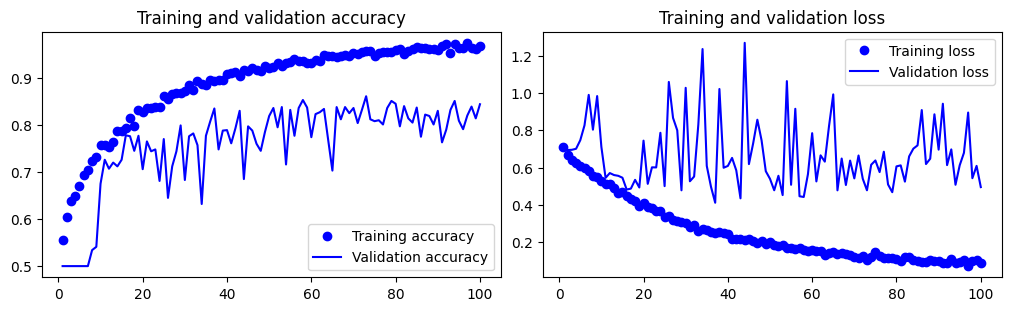

In [25]:
plot_history(history)

In [26]:
test_loss, test_acc = model.evaluate(test_dataset, verbose=0)
print(f"Test accuracy: {test_acc:.3f}")

Test accuracy: 0.849


### Summary

- **Residual connections**: for stability;
- **Batch / Layer normalisation**: for stability;
- **Separable Depthwise Convolutions**: optimising convolutions;
- **Xception**: a vision model including these elements.